<a href="https://colab.research.google.com/github/junho328/Deep_learning_with_Pytorch/blob/main/Pytorch_CH10_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CAM (Class Activation MAP)
- 이미지 분류 결과를 해석
- 이미지 분류 문제에서 이미지 내에 어느 영역을 보고 클래스 분류를 결정했는지를 설명하는 시각화 방법
- 합성곱 신경망의 마지막 층에서 나온 피쳐맵과 분류기의 가중치를 이용해 영역을 찾아 내는 방식
- CAM은 합성곱 신경망의 마지막 층에서의 각각의 피쳐맵의 평균값을 사용하는 GAP(Global Average Pooling)을 사용한다 (위치 정보 소실 방지)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
# 데이터 불러오기
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root='./data',split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 40, shuffle=True)
testset = torchvision.datasets.STL10(root='./data',split='test',download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=40, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 모델 불러오기
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# 정확도 확인
def acc(dataloader):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for data in dataloader:
      images,labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.detach(),1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Accuracy: %d%%'%(100*correct/total))

acc(trainloader)
acc(testloader)

Accuracy: 7%
Accuracy: 7%


In [5]:
# CAM 구축
activation = {}
def get_activation(name):
  def hook(model,input,output):
    activation[name] = output.detach()
  return hook

In [6]:
def cam(dataset, img_sample, img_size):
  model.eval()
  with torch.no_grad():
    model.layer4[1].bn2.register_forward_hook(get_activation('final'))
    data, label = dataset[img_sample]
    data.unsqueeze_(0)
    output = model(data.to(device))
    _, prediction = torch.max(output, 1)
    act = activation['final'].squeeze()
    w = model.fc.weight
    for idx in range(act.size(0)):
      if idx == 0:
        tmp = act[idx] * w[prediction.item()][idx]
      else:
        tmp += act[idx] * w[prediction.item()][idx]
    
    normalized_cam = tmp.cpu().numpy()
    normalized_cam = (normalized_cam-np.min(normalized_cam))/(np.max(normalized_cam)-np.min(normalized_cam))
    original_img = np.uint8(data[0][0]/2+0.5)*255
    cam_img = cv2.resize(np.uint8(normalized_cam*255),dsize=(img_size,img_size))
  return cam_img, original_img, prediction, label                 

In [9]:
# CAM 결과 산출 함수 정의
def plot_cam(dataset, img_size,start):
  end = start + 20
  fig, axs = plt.subplots(2, (end-start+1)//2, figsize=(20,4))
  fig.subplots_adjust(hspace=.01, wspace=.01)
  axs = axs.ravel()
  cls = ['airplane','bird','car','cat','deer','dog','horse','monkey','ship','truck']
  for i in range(start,end):
    cam_img, original_img, prediction, label = cam(dataset, i , img_size)
    if prediction == label:
      color = 'white'
    else:
      color = 'red'
    
    axs[i-start].imshow(original_img, cmap='gray')
    axs[i-start].imshow(cam_img, cmap='jet', alpha=.4)
    axs[i-start].text(5,5, cls[prediction],bbox= {'facecolor':color, 'pad':5})
    axs[i-start].axis('off')
  plt.show()

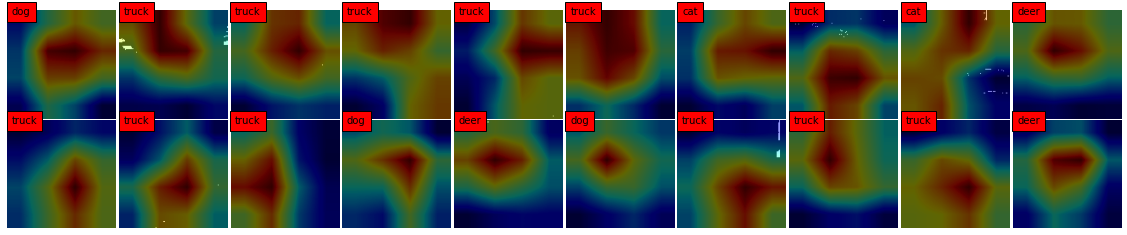

In [10]:
# CAM 결과 산출
plot_cam(trainset, 128, 10)

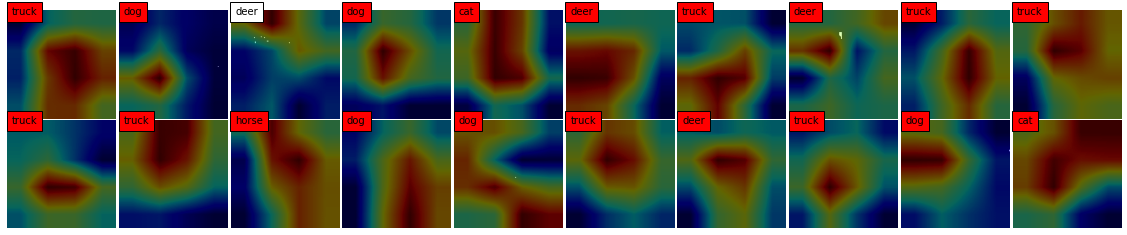

In [11]:
plot_cam(testset, 128, 10)

#차원 축소 기법

### t-distributed Stochastic Neighbor Embedding

In [12]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=16)

In [17]:
# 모델 불러오기
class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  def forward(self, x):
    return x

model = torchvision.models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(3,64, kernel_size=3, stride=1, padding=1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model.fc = Identity()

In [18]:
# 피쳐맵과 예측값 저장하기
actual = []
deep_features = []
model.eval()
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    features = model(images)
    deep_features += features.cpu().tolist()
    actual += labels.cpu().tolist()

In [19]:
# t-SNE 정의
tsne = TSNE(n_components = 2, random_state= 0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


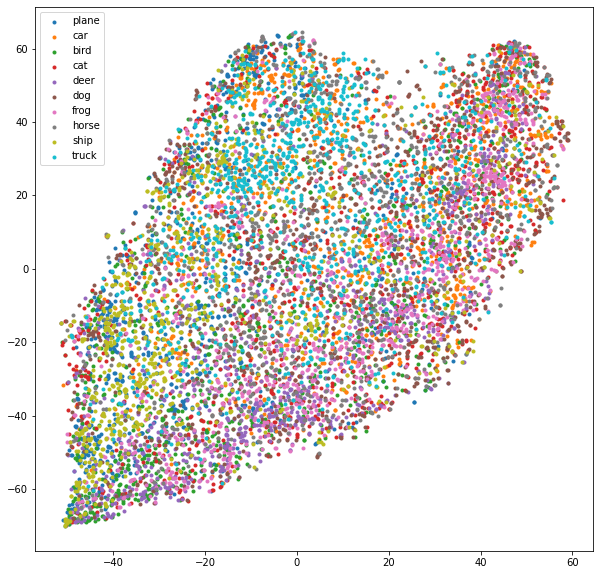

In [20]:
# t-SNE 그래프 그리기
plt.figure(figsize=(10,10))
cifar = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
for i, label in zip(range(10),cifar):
  idx = np.where(actual == i)
  plt.scatter(cluster[idx,0], cluster[idx,1], marker='.', label=label)
plt.legend()
plt.show()

### PCA (Principle Component Analysis)
- t-SNE의 차원 축소는 PCA보다 본래 특성을 덜 훼손하지만 차원 축소된 값을 활용하는데 한계가 있다
- 반면에 PCA는 데이터의 고윳값을 이용해 분석을 하기 때문에 클러스터링 및 데이터 분석에 활용도가 크다 

In [21]:
# PCA 정의
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
cluster = np.array(pca.fit_transform(np.array(deep_features))) 
print(pca.explained_variance_ratio_) # 영향도 파악

[0.59128529 0.0418896 ]


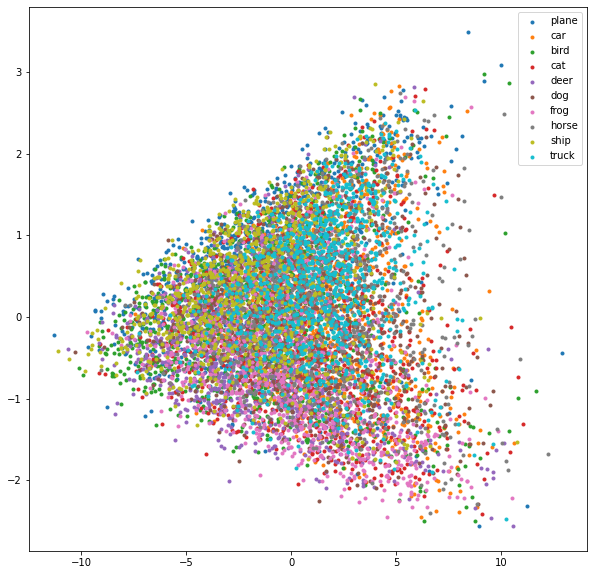

In [22]:
# PCA 그래프 그리기
plt.figure(figsize=(10,10))

for i,label in zip(range(10),cifar):
  idx = np.where(actual==i)
  plt.scatter(cluster[idx,0], cluster[idx,1], marker='.', label=label)
plt.legend()
plt.show()